In [1]:
!pip install --upgrade mplfinance
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.9 MB/s eta 0:00:00


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc
from google.colab import drive
drive.mount('/content/drive')

# Basic libraries
import numpy as np
import pandas as pd
# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
from datetime import datetime
from pyspark.sql.functions import rand, to_timestamp, to_date, avg, col, month, monotonically_increasing_id, lit
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.window import Window


# For visualization
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import MinMaxScaler

import ipywidgets as widgets
from IPython.display import display
import os


Mounted at /content/drive


In [4]:
def on_change(change):
    global company_Name
    if change['type'] == 'change' and change['name'] == 'value':
        company_Name = change['new']
        print(f'Selected: {company_Name}')

options = ['None','Air Liquide','Airbus ','ArcelorMittal','Atos','AXA','BNP Paribas','Bouygues','Cap Gemini','CrÃ©dit Agricole','Danone','Dassault SystÃ¨mes','Engie (ex GDF Suez','EssilorLuxottica','HermÃ¨s (Hermes International','Kering','LEGRAND','LOrÃ©al','LVMH Moet Hennessy Louis Vuitton','Michelin (Compagnie GÃ©nÃ©rale d Etablissements Michelin SCPA','Orange','Pernod Ricard','Peugeot','Publicis','Renault','SAFRAN','Saint-Gobain','Accor','Sanofi','Schneider Electric','SociÃ©tÃ© GÃ©nÃ©rale (Societe Generale','Sodexo','STMicroelectronics','TOTAL','Unibail-Rodamco','Veolia Environnement','VINCI','Vivendi','Worldline SA',
]

dropdown = widgets.Dropdown(options=options, description='Select Company:')

# Display the dropdown
display(dropdown)

# Attach the event handler to the dropdown
dropdown.observe(on_change)



Dropdown(description='Select Company:', options=('None', 'Air Liquide', 'Airbus ', 'ArcelorMittal', 'Atos', 'A…

Selected: AXA


In [6]:
# Reading our dataset
df = spark.read.csv("/content/drive/MyDrive/H516/Project/preprocessed_CAC40.csv", header="TRUE")
# df.show()

# Dropping unnecessary column
df = df.drop('_c0')

# Defining a function that will contain stocks data for a specific company
def specific_data(company, start, end):
    company_data = df[df['Name'] == company]
    date_filtered_data = company_data[(company_data['Date'] > start) & (company_data['Date'] < end)]
    return date_filtered_data

# Setting the start and end date
start_date = dt.datetime(2014,1,1)
end_date = dt.datetime(2020,1,1)

# Calling our function to get data for entered company above
specific_df = specific_data(company_Name, start_date, end_date)
specific_df = specific_df.dropna()


In [7]:
# Convert 'Date' column to datetime
specific_df = specific_df.withColumn('Date',(to_date(specific_df['Date'])))
specific_df.show()

+----+----------+-----+-------------+----------+---------+------+
|Name|      Date| Open|Closing_Price|Daily_High|Daily_Low|Volume|
+----+----------+-----+-------------+----------+---------+------+
| AXA|2019-12-30|25.31|        25.28|     25.31|    25.24| 4,199|
| AXA|2019-12-27|25.45|        25.27|     25.45|    25.27|  1,15|
| AXA|2019-12-23|25.41|        25.31|     25.41|    25.29| 6,698|
| AXA|2019-12-20|25.04|         25.4|      25.4|    25.03| 9,469|
| AXA|2019-12-19| 25.1|        24.98|      25.1|    24.98| 7,995|
| AXA|2019-12-18|25.08|        25.09|     25.11|    25.01|  9,39|
| AXA|2019-12-17|24.89|        25.06|     25.07|    24.86| 10,76|
| AXA|2019-12-16|24.99|         25.0|      25.0|    24.85| 8,406|
| AXA|2019-12-13|25.01|        24.81|     25.08|     24.8|10,546|
| AXA|2019-12-12|24.56|        24.78|     24.78|    24.52| 8,303|
| AXA|2019-12-11|24.66|        24.56|     24.66|     24.5|  4,52|
| AXA|2019-12-10|24.76|        24.63|     24.76|    24.45| 8,264|
| AXA|2019

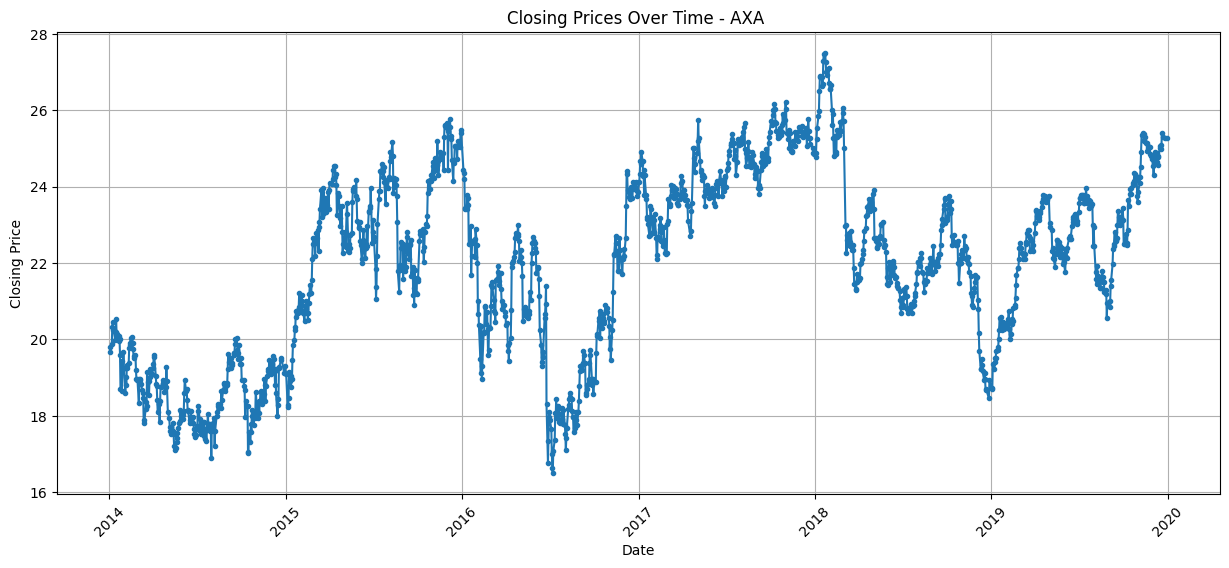

In [8]:
# Line Chart of Closing Prices Over Time
x = specific_df.select('Date').rdd.map(lambda r: r[0]).collect()
y = specific_df.select('Closing_Price').rdd.map(lambda r: r[0]).collect()
y_list = [float(x) for x in y]
plt.figure(figsize=(15, 6))
plt.title(f'Closing Prices Over Time - {company_Name} ')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.plot(x, y_list, marker='.')
plt.show()


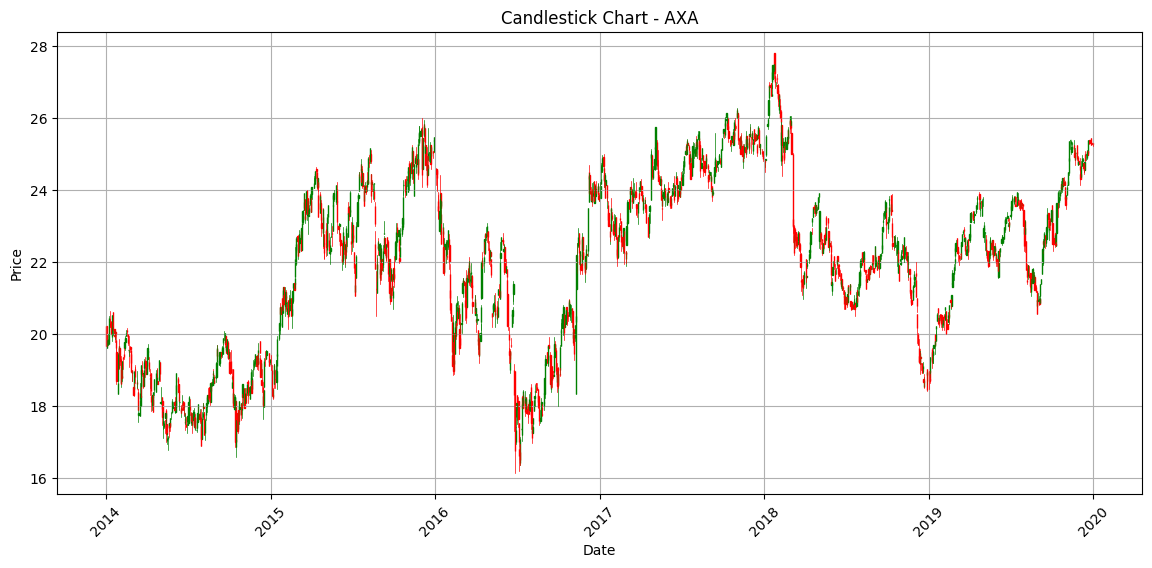

In [9]:
# Candlestick Chart

x = date2num(specific_df.select('Date').rdd.map(lambda r: r[0]).collect())
y = [float(x) for x in specific_df.select('Open').rdd.map(lambda r: r[0]).collect()]
z = [float(x) for x in specific_df.select('Daily_High').rdd.map(lambda r: r[0]).collect() ]
a = [float(x) for x in specific_df.select('Daily_Low').rdd.map(lambda r: r[0]).collect()]
b = [float(x) for x in specific_df.select('Closing_Price').rdd.map(lambda r: r[0]).collect()]

# Create an array of tuples in the required format
ohlc = np.vstack((x, y, z, a, b)).T
plt.figure(figsize=(14, 6))
ax = plt.subplot()
ax.xaxis_date()
plt.title(f'Candlestick Chart - {company_Name}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
plt.show()

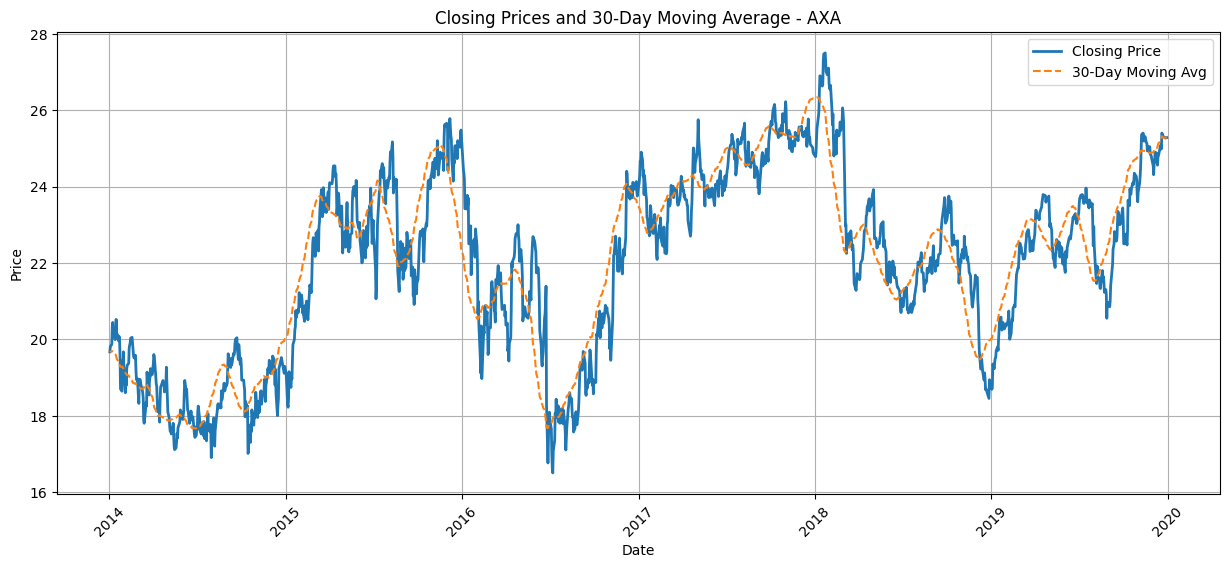

In [10]:
# Closing Prices and Moving Average plot

window=30
plt.figure(figsize=(15, 6))
window_spec = Window().rowsBetween(-29, 0)
df_with_avg = specific_df.withColumn("30_day_avg", avg("Closing_Price").over(window_spec))
plt.plot(specific_df.select('Date').rdd.map(lambda r: r[0]).collect(), [float(x) for x in specific_df.select('Closing_Price').rdd.map(lambda r: r[0]).collect()], label='Closing Price', linewidth=2)
#plt.plot(specific_df.select('Date').rdd.map(lambda r: r[0]).collect(), [float(x) for x in specific_df.select('Closing_Price').rdd.map(lambda r: r[0]).collect()].mean(), label=f'{window}-Day Moving Avg', linestyle='--')
plt.plot(specific_df.select('Date').rdd.map(lambda r: r[0]).collect(), [float(x) for x in df_with_avg.select('30_day_avg').rdd.map(lambda r: r[0]).collect()] , label=f'{window}-Day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-Day Moving Average - {company_Name}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

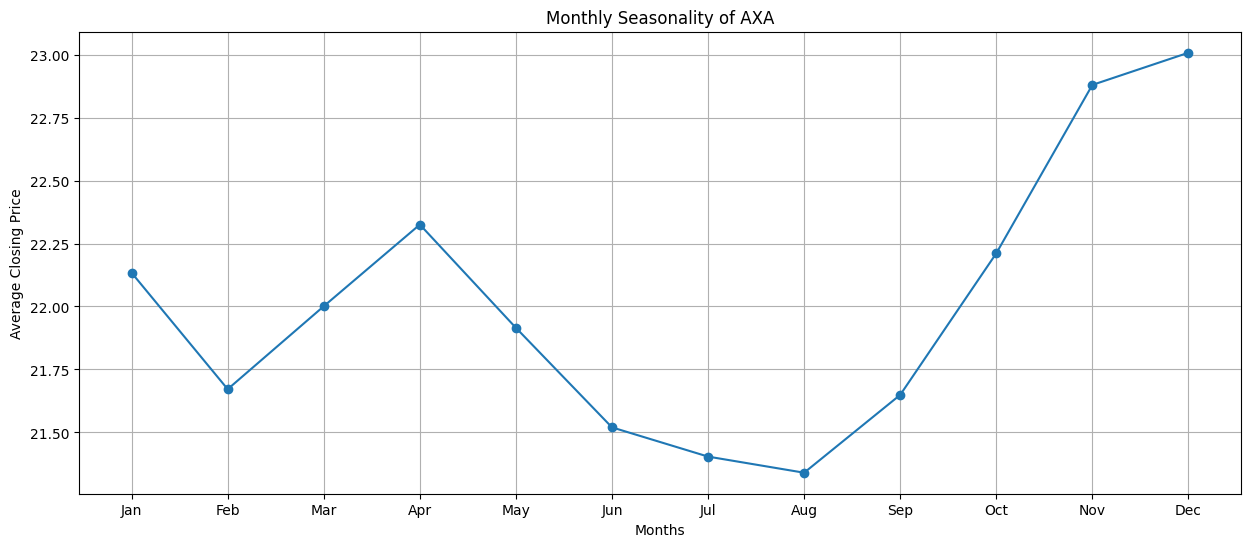

In [11]:
# Monthly Seasonality of Closing Prices

df_with_month = specific_df.withColumn("Month", month(col("Date")))

monthly_avg_df = df_with_month.groupBy("Month").agg(avg("Closing_Price").alias("Monthly_Average")).orderBy("Month")

plt.figure(figsize=(15, 6))
plt.plot(monthly_avg_df.select('Month').rdd.map(lambda r: r[0]).collect(), monthly_avg_df.select('Monthly_Average').rdd.map(lambda r: r[0]).collect(), marker='o')
plt.title(f'Monthly Seasonality of {company_Name}')
plt.xlabel('Months')
plt.ylabel('Average Closing Price')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

In [ ]:
#specific_df.show()

In [12]:

indexed_df = specific_df.withColumn('index', monotonically_increasing_id())
#indexed_df1 = indexed_df.withColumn('Closing_Price', indexed_df['Closing_Price'])
new_df = indexed_df.select('index','Closing_Price')
new_df = new_df.withColumn('Closing_Price', new_df['Closing_Price'].cast(FloatType()))
#new_df.show()

In [13]:


# Convert 'Closing_Price' column to a Vector column
new_df = new_df.withColumn("Closing_Price_Vector", col("Closing_Price").cast("double"))
assembler = VectorAssembler(inputCols=["Closing_Price_Vector"], outputCol="Closing_Price_Vector_Assembled")
new_df = assembler.transform(new_df)

# Initialize MinMaxScaler
scaler = MinMaxScaler(inputCol="Closing_Price_Vector_Assembled", outputCol="scaled_Closing_Price")

# Compute summary statistics and normalize the data
scaler_model = scaler.fit(new_df)
normalized_df = scaler_model.transform(new_df)

# Display normalized data
#normalized_df.show()

scaled_data = normalized_df.select('scaled_Closing_Price').rdd.map(lambda r: r[0]).collect()
#print(scaled_data)

scaled_data = np.array(scaled_data)

# Get minimum and maximum values used for scaling
min_val = scaler_model.originalMin
max_val = scaler_model.originalMax

# Split into training and testing sets
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Define the sequence length (number of past time steps)
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i,0])
    y_train.append(train_data[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train_org = X_train
# Prepare sequences for LSTM - Test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i,0])
    y_test.append(test_data[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test_org = X_test
# print(min_val, max_val)



In [14]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1151, 60)
(1151,)


Testing set size:-
(243, 60)
(243,)


(None, None)

In [15]:
# Reshape input data for LSTM([samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Initialize a sequential model
model = Sequential()

# First LSTM layer with 50 units, input shape, and return sequences
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))  # Adding dropout to prevent overfitting

# Second LSTM layer with 50 units and return sequences
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer with 50 units
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [16]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [17]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath = 'my_weights.h5', save_best_only = True)
# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our lstm model
model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/100
36/36 [==============================] - 15s 219ms/step - loss: 0.0471 - val_loss: 0.0100
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 4s 116ms/step - loss: 0.0130 - val_loss: 0.0061
Epoch 3/100
36/36 [==============================] - 4s 104ms/step - loss: 0.0101 - val_loss: 0.0041
Epoch 4/100
36/36 [==============================] - 4s 114ms/step - loss: 0.0101 - val_loss: 0.0048
Epoch 5/100
36/36 [==============================] - 6s 165ms/step - loss: 0.0089 - val_loss: 0.0051
Epoch 6/100
36/36 [==============================] - 4s 121ms/step - loss: 0.0096 - val_loss: 0.0038
Epoch 7/100
36/36 [==============================] - 4s 108ms/step - loss: 0.0085 - val_loss: 0.0031
Epoch 8/100
36/36 [==============================] - 4s 104ms/step - loss: 0.0076 - val_loss: 0.0034
Epoch 9/100
36/36 [==============================] - 6s 168ms/step - loss: 0.0076 - val_loss: 0.0030
Epoch 10/100
36/36 [==============================] - 5s 127ms/step - loss: 0.0075 - val_loss: 0.0030
Epoch 11/100
36/36 [==============================] - 4s 114ms/step - loss: 0.0070 - val_loss: 0.0028


In [18]:
# Let's do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
# print(train_predict)
# print(test_predict)

# Transform back to original form
# Define a function to perform the inverse normalization
def inverse_normalization(value, min_val, max_val):
    return value * (max_val - min_val) + min_val

# Assuming min_val and max_val are the minimum and maximum values of your original data before scaling
# min_val = 16.5
# max_val = 27.5

min_val= min_val
max_val = max_val
#print(min_val, max_val)

# Perform inverse normalization for train_predict and test_predict
train_predict = [inverse_normalization(pred, min_val, max_val) for pred in train_predict]
test_predict = [inverse_normalization(pred, min_val, max_val) for pred in test_predict]

train_predict = np.array(train_predict)
test_predict = np.array(test_predict)
# print(train_predict)
# print(test_predict)

# Calculate train data RMSE
print("Root mean Squared Error(Training Data) : ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Mean Absolute Error(Training Data) : ", mean_absolute_error(y_train,train_predict))
# Calculate test data RMSE
print("Root mean Squared Error(Test Data) : ",math.sqrt(mean_squared_error(y_test,test_predict)))
print("Mean Absolute Error(Test Data) : ",mean_absolute_error(y_test,test_predict))

8/8 [==============================] - 0s 39ms/step
Root mean Squared Error(Training Data) :  22.18000332318954
Mean Absolute Error(Training Data) :  22.1060953699326
Root mean Squared Error(Test Data) :  18.42750426575805
Mean Absolute Error(Test Data) :  18.4131947414698


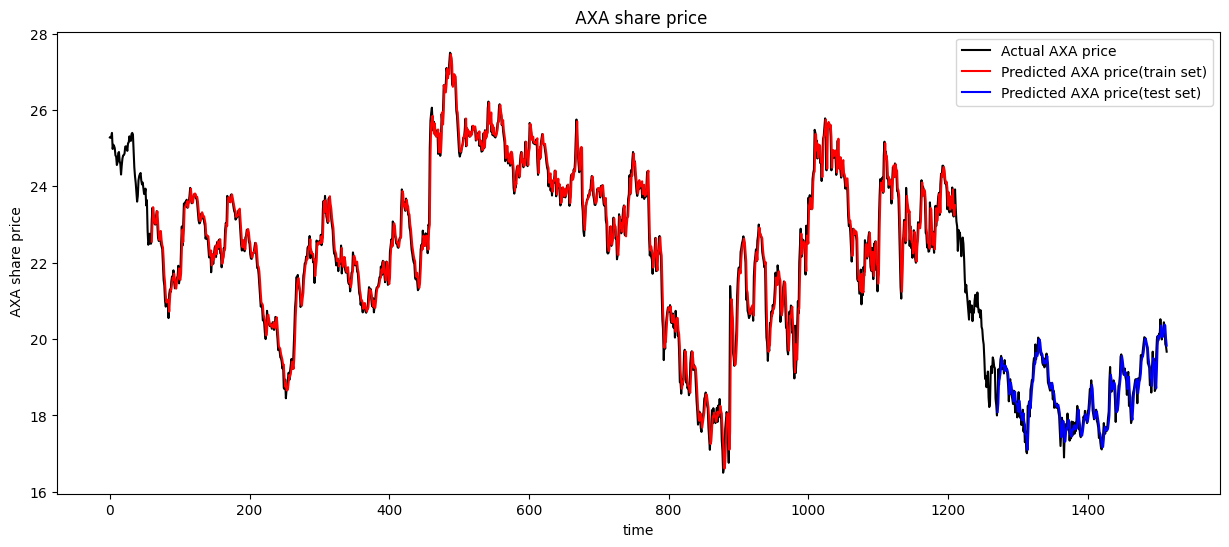

In [19]:
# Set the number of previous time steps to consider for plotting
look_back = 60

new_df = new_df.select('Closing_Price')
pandas_series = pd.Series(new_df.rdd.flatMap(lambda x: x).collect())

# Initialize an array for plotting the train predictions
trainPredictPlot = np.empty_like(pandas_series)

trainPredictPlot[:] = np.nan

# Assign the predicted values to the appropriate location for train predictions

trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()


# Initialize an array for plotting the test predictions
testPredictPlot = np.empty_like(pandas_series)
testPredictPlot[:] = np.nan
# Calculate the starting index for the test predictions
test_start = len(pandas_series) - len(test_predict)

# Assign the predicted values to the appropriate location for test predictions
testPredictPlot[test_start:] = test_predict.flatten()


# Rescale the scaled data back to its original scale using the scaler
original_scaled_data = [inverse_normalization(pred, min_val, max_val) for pred in scaled_data]

# Plotting the baseline data, training predictions, and test predictions
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual {company_Name} price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted {company_Name} price(train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted {company_Name} price(test set)")

plt.title(f" {company_Name} share price")
plt.xlabel("time")
plt.ylabel(f" {company_Name} share price")
plt.legend()
plt.show()

1/1 [==============================] - 0s 49ms/step
Predictions for the next 10 days:
Day 1: Predicted Price = [19.82872814]
Day 2: Predicted Price = [19.81118685]
Day 3: Predicted Price = [19.82715851]
Day 4: Predicted Price = [19.84446442]
Day 5: Predicted Price = [19.85938704]
Day 6: Predicted Price = [19.87232763]
Day 7: Predicted Price = [19.88378152]
Day 8: Predicted Price = [19.89391592]
Day 9: Predicted Price = [19.90269968]
Day 10: Predicted Price = [19.91006559]


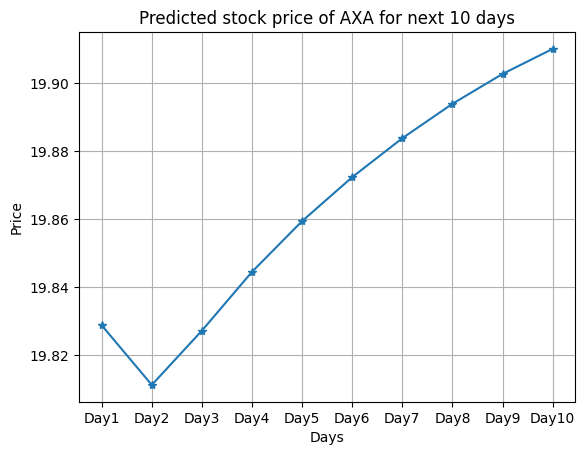

In [20]:
# To predict for the next 10 days, you'll need the last n_past days of data
last_sequence = X_test[-1]


# Reshape the last_sequence to match the input shape of the model
last_sequence = last_sequence.reshape(1, n_past, 1)

# Generate predictions for the next 10 days
predictions_next_10_days = []
for _ in range(10):
    next_day_prediction = model.predict(last_sequence)
    predictions_next_10_days.append(next_day_prediction[0, 0])  # Get the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1)  # Shift the sequence by one day
    last_sequence[0, -1, 0] = next_day_prediction  # Update the last element with the new prediction

# Transform the predictions back to the original scale
#predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))
predictions_next_10_days = [inverse_normalization(pred, min_val, max_val) for pred in np.array(predictions_next_10_days).reshape(-1, 1)]


# Print the predictions for the next 10 days
print("Predictions for the next 10 days:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
  print(f"Day {i}: Predicted Price = {prediction}")
#print(predictions_next_10_days)

plt.plot(predictions_next_10_days, marker='*')
plt.title(f'Predicted stock price of {company_Name} for next 10 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 10), ['Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10'])
plt.grid(True)
plt.show()

In [21]:
from pyspark.sql.functions import lag, col
# windowSpec = Window.orderBy("Date")
# specific_df = specific_df.withColumn("Closing_Price_Lagged", lag("Closing_Price").over(windowSpec))
#new_df = new_df.withColumn('Closing_Price', new_df['Closing_Price'].cast(FloatType()))
naya_df = specific_df
for col_name in [ 'Open', 'Daily_High', 'Daily_Low', 'Closing_Price']:
    naya_df = naya_df.withColumn(col_name, col(col_name).cast("double"))

naya_df = naya_df.dropna()

#naya_df.show()


In [24]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator



# Define features and target variable
features = ['Open', 'Daily_High', 'Daily_Low']  # Adjust features as needed
target = 'Closing_Price'  # Define the target variable

# Assemble features into a vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(naya_df)

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2])

# Initialize and train the Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol=target, numTrees=100)
rf_model = rf.fit(train_data)

# Make predictions on the test data
rf_predictions = rf_model.transform(test_data)
#rf_predictions.show()
# print(specific_df.select('Date').rdd.map(lambda r: r[0]).collect())
# Evaluate the Random Forest model
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
rf_rmse = evaluator.evaluate(rf_predictions)
print(f"Random Forest RMSE: {rf_rmse}")

Random Forest RMSE: 0.22723332771306143


In [23]:
from pyspark.ml.regression import GBTRegressor

# Initialize and train the Gradient Boosted Tree Regressor
gbt = GBTRegressor(featuresCol="features", labelCol=target, maxIter=100, seed=42)
gbt_model = gbt.fit(train_data)

# Make predictions on the test data
gbt_predictions = gbt_model.transform(test_data)

# Evaluate the Gradient Boosted Tree model
gbt_rmse = evaluator.evaluate(gbt_predictions)
print(f"Gradient Boosted Tree RMSE: {gbt_rmse}")

Gradient Boosted Tree RMSE: 0.22376928995591588


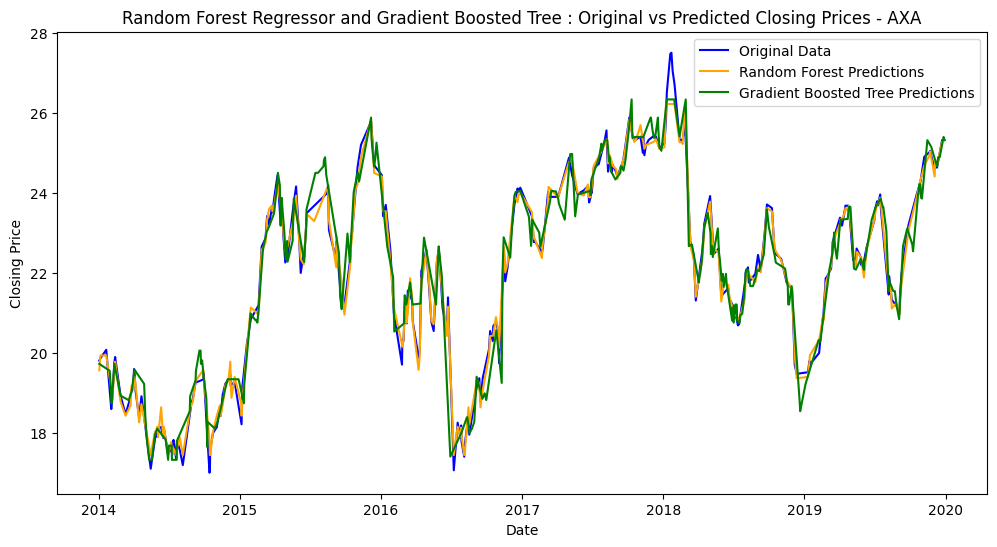

In [25]:

x = rf_predictions.select('Date').rdd.map(lambda r: r[0]).collect()
y = rf_predictions.select('Closing_Price').rdd.map(lambda r: r[0]).collect()
z = rf_predictions.select('prediction').rdd.map(lambda r: r[0]).collect()
x1 = gbt_predictions.select('Date').rdd.map(lambda r: r[0]).collect()
y1 = gbt_predictions.select('Closing_Price').rdd.map(lambda r: r[0]).collect()
z1 = gbt_predictions.select('prediction').rdd.map(lambda r: r[0]).collect()
# # Sort predictions by date for proper plotting
# rf_pred_pd = rf_pred_pd.sort_values('Date')
# gbt_pred_pd = gbt_pred_pd.sort_values('Date')

# Plotting the comparison
plt.figure(figsize=(12, 6))

# Original Closing Price vs Random Forest Predictions
plt.plot(x, y, label='Original Data', color='blue')
plt.plot(x, z, label='Random Forest Predictions', color='orange')
plt.plot(x1, z1, label='Gradient Boosted Tree Predictions', color='green')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title(f'Random Forest Regressor and Gradient Boosted Tree : Original vs Predicted Closing Prices - {company_Name}')
plt.legend()
plt.show()